# Analyze C reactive proteins

This is a blood test marker for inflammation in the body

In [1]:
using Distributed
addprocs(30)
nprocs()

31

In [2]:
using MendelIHT
using SnpArrays
using DataFrames
using Distributions
using BenchmarkTools
using Random
using LinearAlgebra
using GLM
using CSV
using Dates

# Import data

+ ** For description of what each phenotype column means**, see here:
https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/dataset.cgi?study_id=phs000276.v2.p1&phv=129612&phd=&pha=2896&pht=2005&phvf=&phdf=&phaf=&phtf=&dssp=1&consent=&temp=1

+ **We have already matched up phenotype with genotypes** in the files below

In [4]:
# import full genotype data
kevin_stampeed = SnpArray("../kevin_imputed.bed")

# import full phenotype data
phenotype_data = CSV.read("full_phenotype_sorted", delim=',', header=true)

,dbGaP_Subject_ID,SUBJID,SEX,a10atc,crp3dec,FASTING_STATUS,FB_GLUK,FS_INS,FS_KOL,FS_KOL_H,FS_KOL_L,FS_TRIGL,HOMA_IR,PAILAHDE,Pills31,PITLAHDE,ZP4202U,ZT20,ZT27,ZT28,ZT29,ZT30,CASE,RACE,BMI,Systolic Blood Pressure MEAN,Diastolic Blood Pressure MEAN
,Int64⍰,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰
1,356529,2864,2,0,0.373,0,4.8,8.8,6.73,2.26,4.2,0.64,1.13,1,1,1,1,2,166.8,55.7,92.4,71.8,2,Caucasian,20,110,79
2,358247,2374,1,0,0.38,0,5.6,7,3.95,1.55,2.1,0.67,0.94,1,X,1,X,X,179.6,67.2,92.5,79,2,Caucasian,20.8,117,72
3,356035,2803,1,0,9.214,0,5.7,12.9,7.44,1.19,5.6,1.52,1.72,1,X,1,X,X,177,101.7,112,117,2,Caucasian,32.5,147,97
4,353849,4709,1,0,0.61,0,4.9,8.7,3.92,1.44,2.3,0.35,1.12,1,X,1,X,X,173.4,89.9,103,102,2,Caucasian,29.9,125,60
5,354502,4350,1,0,0.593,0,4.9,3.6,3.53,1.53,1.8,0.39,0.47,1,X,1,1,2,170.8,66.5,90,75,2,Caucasian,22.8,X,X
6,356015,3480,2,0,1.774,0,4.7,8.7,3.59,1.48,1.8,0.69,1.11,1,0,1,0,2,170.5,71.6,99,78,2,Caucasian,24.6,138,84
7,356268,3729,1,0,2.564,0,4.6,5.7,5.71,2.01,3.4,0.6,0.73,1,X,1,X,X,182,73.5,91,84,2,Caucasian,22.2,132,76
8,358341,4031,1,0,3.998,0,5.9,7.6,4.11,1.31,2.3,1.03,1.03,1,X,1,X,X,182.3,85.4,102,92,2,Caucasian,25.7,132,100
9,357054,1104,1,0,3.238,0,5.4,12.2,5.93,0.92,3.5,3.24,1.6,1,X,1,X,X,178.4,91.1,102,99,2,Caucasian,28.6,140,110


# Filtered phenotype and genotype data for crp3dec

In [6]:
# exclude samples without HDL measurements
cprotein = phenotype_data[:crp3dec]
missing_cprotein_data = cprotein .== "X"

# exclude people that are fasting
fasting_data = phenotype_data[:FASTING_STATUS]
contains_nonfasting_blood = (fasting_data .== "1") .+ (fasting_data .== "X")

# exlucde people on diabetes medication
diabetes_med = phenotype_data[:a10atc]
contains_diabetes_medication = (diabetes_med .== "1") .+ (diabetes_med .== "X")

# exclude SNPs with maf < 0.01 and SNPs with HWE p-value < 0.00001
rowmask, snps_to_keep = SnpArrays.filter(kevin_stampeed, min_success_rate_per_row=1.0, 
    min_success_rate_per_col=1.0, min_maf=0.01, min_hwe_pval=1e-5)

# combine
samples_to_exclude = missing_cprotein_data .+ contains_nonfasting_blood .+ contains_diabetes_medication .+ rowmask
samples_to_keep = samples_to_exclude .== 0

@show count(snps_to_keep)
@show count(samples_to_keep)

count(snps_to_keep) = 324789
count(samples_to_keep) = 4896


4896

In [8]:
SnpArrays.filter("../kevin_imputed", samples_to_keep, snps_to_keep, des="kevin_imputed_filtered_cprotein")

4896×324789 SnpArray:
 0x03  0x03  0x03  0x03  0x03  0x03  …  0x03  0x02  0x03  0x03  0x03  0x03
 0x03  0x02  0x02  0x02  0x02  0x03     0x03  0x03  0x02  0x03  0x03  0x03
 0x02  0x03  0x03  0x03  0x02  0x03     0x02  0x02  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x02  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x02  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x02  0x03  …  0x03  0x02  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x02  0x03     0x02  0x02  0x02  0x02  0x02  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x02  0x02  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x00  0x00  0x00  0x00  0x03
 0x02  0x00  0x00  0x00  0x03  0x03     0x03  0x02  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x02  0x03  …  0x03  0x00  0x03  0x03  0x03  0x02
 0x03  0x03  0x03  0x03  0x02  0x03     0x03  0x00  0x00  0x03  0x03  0x03
 0x03  0x02  0x02  0x02  0x03  0x03     0x03  0x03  0x00  0x02  0x02  0x03
   

## Compute top 2 principal components on resulting file using plink2

The following command was executed:
```
./plink2 --bfile kevin_imputed_filtered_cprotein --pca 2
```

# Begin analysis

Here we round the phenotype to the nearest integer, so we can model it with a Poisson distribution, which is appropriate because of the shape and values of the distribution.

In [9]:
# first check genotype and phenotype files actually match 
genotype_order = CSV.read("kevin_imputed_filtered_cprotein.fam", delim=' ', header=false)[:, 1]
phenotype_order = phenotype_data[samples_to_keep, 2]
all(phenotype_order .== genotype_order)

true

In [12]:
x = SnpArray("kevin_imputed_filtered_cprotein.bed")
yy = parse.(Float64, cprotein[samples_to_keep])

4896-element Array{Float64,1}:
  0.373
  0.38 
  9.214
  0.61 
  0.593
  1.774
  2.564
  3.998
  3.238
  0.83 
  0.33 
  0.598
  0.365
  ⋮    
  0.346
 29.0  
  2.017
  1.89 
  1.283
  2.379
  0.698
  1.399
  0.084
  0.079
  0.015
  0.092

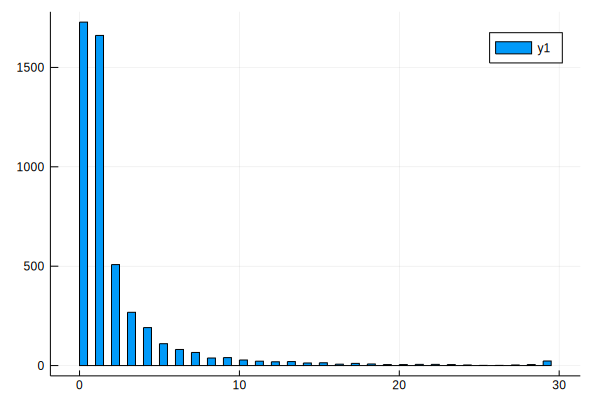

In [14]:
using Plots
y = round.(yy)
histogram(y)

## add non-genetic covariates

In [17]:
n, p = size(x)
z = zeros(n, 4) 

# add intercept
z[:, 1] .= ones(n) 

# add sexOCPG 
for i in 1:n
    if phenotype_data[:SEX][i] == 1 #males
        z[i, 2] = 0.0
    else
        # oral contraceptive: 0 = no, 1 = yes, X = unknown
        # pregnancy: 1 = yes, 2 = no, 3 and X = unknown
        my_covariates = (phenotype_data[:ZP4202U][i], phenotype_data[:ZT20][i])
        
        my_covariates == ("0", "1") && (z[i, 2] = 1)
        my_covariates == ("0", "2") && (z[i, 2] = 2)
        my_covariates == ("0", "3") && (z[i, 2] = 3)
        my_covariates == ("0", "X") && (z[i, 2] = 3)
        
        my_covariates == ("1", "1") && (z[i, 2] = 4)
        my_covariates == ("1", "2") && (z[i, 2] = 5)
        my_covariates == ("1", "3") && (z[i, 2] = 6)
        my_covariates == ("1", "X") && (z[i, 2] = 6)
        
        my_covariates == ("X", "1") && (z[i, 2] = 7)
        my_covariates == ("X", "2") && (z[i, 2] = 8)
        my_covariates == ("X", "3") && (z[i, 2] = 9)
        my_covariates == ("X", "X") && (z[i, 2] = 9)
    end 
end

# add first 2 principal components
pc = CSV.read("kevin_imputed_filtered_cprotein.eigenvec", delim="\t", header=true)
pc1 = pc[:, 3]
pc2 = pc[:, 4]

# standardize all covariates
mean_sexOCPG = mean(z[:, 2])
mean_pc1 = mean(pc1)
mean_pc2 = mean(pc2)
std_pc1 = std(pc1)
std_pc2 = std(pc2)
std_sexOCPG = std(z[:, 2])
z[:, 2] .= (z[:, 2] .- mean_sexOCPG) ./ std_sexOCPG
z[:, 3] .= (pc1 .- mean_pc1) ./ std_pc1
z[:, 4] .= (pc2 .- mean_pc2) ./ std_pc2

4896-element view(::Array{Float64,2}, :, 4) with eltype Float64:
  0.11805494288421252 
 -0.7302241079651797  
 -0.4060369447590449  
  0.2204350654372114  
 -0.4713150124027586  
 -1.2102979721383695  
  0.3843270787231813  
 -0.17659330351502    
 -0.5320118193346864  
 -0.719491588215822   
 -0.7328617611239201  
 -0.766430620157439   
 -0.03641666066139218 
  ⋮                   
 -0.09917433527087594 
 -0.9767222408265672  
 -0.713264767761501   
 -0.3435980273854026  
 -0.23933096834192022 
 -0.1509423014569562  
  0.2525080882761979  
 -0.42601034591971393 
  0.040246203665337876
  0.08438043779579449 
 -0.4600122838140446  
  0.06601481566928614 

# Run Cross validation

In [27]:
#set seed
Random.seed!(2019)

d = Poisson
l = canonicallink(d())
path = collect(1:20)
num_folds = 5
folds = rand(1:num_folds, size(x, 1))

4896-element Array{Int64,1}:
 5
 5
 4
 3
 4
 4
 4
 1
 4
 5
 4
 4
 4
 ⋮
 2
 4
 4
 3
 5
 2
 2
 3
 4
 5
 1
 1

In [30]:
println("start time = " * string(Dates.format(now(), "HH:MM")))
mses = cv_iht(d(), l, x, z, y, 1, path, folds, num_folds, debias=false, parallel=true)

start time = 13:32


Crossvalidation Results:
	k	MSE
	1	3897.834161058795
	2	3869.7207497378595
	3	3875.464364667047
	4	3881.7597862973034
	5	3881.301041614355
	6	3926.440393486184
	7	3935.1907641154326
	8	3959.666066476349
	9	3942.0254520427748
	10	3967.194449022847
	11	3998.937310487884
	12	4012.536733348584
	13	4062.9261920450226
	14	4095.6958654531268
	15	4132.3867019731915
	16	4120.222018388735
	17	4168.470834131187
	18	4179.092163996812
	19	4199.831868164844
	20	4238.812830675342

The lowest MSE is achieved at k = 2 



20-element Array{Float64,1}:
 3897.834161058795 
 3869.7207497378595
 3875.464364667047 
 3881.7597862973034
 3881.301041614355 
 3926.440393486184 
 3935.1907641154326
 3959.666066476349 
 3942.0254520427748
 3967.194449022847 
 3998.937310487884 
 4012.536733348584 
 4062.9261920450226
 4095.6958654531268
 4132.3867019731915
 4120.222018388735 
 4168.470834131187 
 4179.092163996812 
 4199.831868164844 
 4238.812830675342 

In [31]:
println("end time = " * string(Dates.format(now(), "HH:MM")))

end time = 14:18


# Run with full dataset on best $k$

In [32]:
xbm = SnpBitMatrix{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true); 
@show k = argmin(mses)
d = Normal
l = canonicallink(d())
result = L0_reg(x, xbm, z, y, 1, k, d(), l, debias=true)

k = argmin(mses) = 2


IHT results:

Compute time (sec):     48.95480012893677
Final loglikelihood:    -13417.337802932956
Iterations:             3
Max number of groups:   1
Max predictors/group:   2
IHT estimated 1 nonzero SNP predictors and 1 non-genetic predictors.

Genetic predictors:
1×2 DataFrame
│ Row │ Position │ Estimated_β │
│     │ Int64    │ Float64     │
├─────┼──────────┼─────────────┤
│ 1   │ 236952   │ 0.313856    │

Nongenetic predictors:
1×2 DataFrame
│ Row │ Position │ Estimated_β │
│     │ Int64    │ Float64     │
├─────┼──────────┼─────────────┤
│ 1   │ 1        │ 2.00797     │

In [33]:
estimated_b = result.beta
position = findall(!iszero, estimated_b)
found_snps = CSV.read("kevin_imputed_filtered_cprotein.bim", delim='\t', header=false)[position, :]

,Column1,Column2,Column3,Column4,Column5,Column6
,Int64⍰,String⍰,Int64⍰,Int64⍰,String⍰,String⍰
1,12,rs1169300,0,119915608,A,G


In [34]:
result = L0_reg(x, xbm, z, y, 1, k, d(), l, debias=false)

IHT results:

Compute time (sec):     46.23880100250244
Final loglikelihood:    -13417.33124841859
Iterations:             3
Max number of groups:   1
Max predictors/group:   2
IHT estimated 1 nonzero SNP predictors and 1 non-genetic predictors.

Genetic predictors:
1×2 DataFrame
│ Row │ Position │ Estimated_β │
│     │ Int64    │ Float64     │
├─────┼──────────┼─────────────┤
│ 1   │ 236952   │ 0.313856    │

Nongenetic predictors:
1×2 DataFrame
│ Row │ Position │ Estimated_β │
│     │ Int64    │ Float64     │
├─────┼──────────┼─────────────┤
│ 1   │ 1        │ 2.00797     │

In [35]:
estimated_b = result.beta
position = findall(!iszero, estimated_b)
found_snps = CSV.read("kevin_imputed_filtered_cprotein.bim", delim='\t', header=false)[position, :]

,Column1,Column2,Column3,Column4,Column5,Column6
,Int64⍰,String⍰,Int64⍰,Int64⍰,String⍰,String⍰
1,12,rs1169300,0,119915608,A,G
